# Stock Market Prediction And Forecasting Using Stacked LSTM

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 5.6 MB/s 


In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Collect Stock Data

In [8]:
df=pd.read_csv('task2-dataset.csv')
df


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [10]:
df1=df.reset_index()['Close']
df1      

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [11]:
df1.shape

(2035,)

Text(0.5, 1.0, 'CLOSING GRAPH OF STOCK-MARKET')

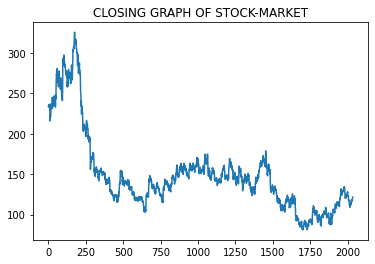

In [12]:
plt.plot(df1)
plt.rcParams['figure.figsize'] = [15,7]
plt.title('CLOSING GRAPH OF STOCK-MARKET')

 # Minmaxscaler

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))   # to scale down everything b/w 0 n 1
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

# PREPROCESSING : TEST-TRAIN SPLIT

In [14]:
train_size = int(len(df1)*0.7)      # taking 70 % data as training data 
test_size = len(df1)-train_size     # rest 30 % as testing data

train_data = df1[0:train_size,:]
test_data = df1[train_size:len(df1),:]

In [15]:
train_data.shape

(1424, 1)

In [16]:
test_data.shape

(611, 1)

# Timesteps to predict the future data 

In [17]:
def select_data(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
timestep = 200

X_train, y_train = select_data(train_data, timestep)
X_test, y_test = select_data(test_data, timestep)
X_train, y_train

(array([[0.62418301, 0.62214052, 0.62622549, ..., 0.84497549, 0.8880719 ,
         0.84763072],
        [0.62214052, 0.62622549, 0.63378268, ..., 0.8880719 , 0.84763072,
         0.82945261],
        [0.62622549, 0.63378268, 0.62234477, ..., 0.84763072, 0.82945261,
         0.79248366],
        ...,
        [0.33047386, 0.32128268, 0.34007353, ..., 0.33415033, 0.33986928,
         0.34681373],
        [0.32128268, 0.34007353, 0.3310866 , ..., 0.33986928, 0.34681373,
         0.3500817 ],
        [0.34007353, 0.3310866 , 0.31495098, ..., 0.34681373, 0.3500817 ,
         0.32618464]]),
 array([0.82945261, 0.79248366, 0.8129085 , ..., 0.3500817 , 0.32618464,
        0.32271242]))

In [19]:
X_test, y_test

(array([[0.32148693, 0.32352941, 0.3255719 , ..., 0.16115196, 0.15175654,
         0.14644608],
        [0.32352941, 0.3255719 , 0.32638889, ..., 0.15175654, 0.14644608,
         0.15216503],
        [0.3255719 , 0.32638889, 0.33496732, ..., 0.14644608, 0.15216503,
         0.1435866 ],
        ...,
        [0.06944444, 0.08088235, 0.07700163, ..., 0.14562908, 0.15236928,
         0.15400327],
        [0.08088235, 0.07700163, 0.0684232 , ..., 0.15236928, 0.15400327,
         0.14971405],
        [0.07700163, 0.0684232 , 0.06781046, ..., 0.15400327, 0.14971405,
         0.1621732 ]]),
 array([0.15216503, 0.1435866 , 0.13419118, 0.1431781 , 0.16115196,
        0.16176471, 0.17320261, 0.18218954, 0.16237745, 0.13112745,
        0.15931373, 0.15951797, 0.14808007, 0.16278595, 0.15625   ,
        0.16319444, 0.16360294, 0.16278595, 0.16544118, 0.15522876,
        0.17197712, 0.1503268 , 0.13255719, 0.14338235, 0.15849673,
        0.1186683 , 0.11519608, 0.10947712, 0.0692402 , 0.06597222,
 

In [20]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(timestep,1)))
model.add(Dropout(0.2))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()
model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs = 50,batch_size = 32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 200, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 200, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

# DOING PREDICTIONS

In [21]:
train_predict=model.predict(X_train)       # output for train dataset
test_predict=model.predict(X_test)        # output for test dataset

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [22]:
train_predict

array([[282.29962],
       [282.48492],
       [279.69562],
       ...,
       [160.5704 ],
       [161.44356],
       [161.41275]], dtype=float32)

In [23]:
test_predict

array([[116.04995 ],
       [116.66493 ],
       [116.65561 ],
       [115.88795 ],
       [114.9838  ],
       [114.84192 ],
       [115.45619 ],
       [116.834946],
       [118.81141 ],
       [120.21577 ],
       [119.76662 ],
       [118.78628 ],
       [117.94735 ],
       [117.112656],
       [116.826836],
       [116.86773 ],
       [117.28308 ],
       [117.91639 ],
       [118.543434],
       [119.11469 ],
       [119.23498 ],
       [119.4896  ],
       [119.24876 ],
       [117.99625 ],
       [116.48486 ],
       [115.6882  ],
       [114.44527 ],
       [112.68013 ],
       [110.63432 ],
       [107.51442 ],
       [103.82118 ],
       [100.15808 ],
       [ 96.91694 ],
       [ 94.32674 ],
       [ 92.63777 ],
       [ 91.986885],
       [ 92.03551 ],
       [ 92.962364],
       [ 94.56014 ],
       [ 95.78143 ],
       [ 96.14247 ],
       [ 95.75521 ],
       [ 95.07078 ],
       [ 94.2722  ],
       [ 93.553314],
       [ 93.02823 ],
       [ 92.662506],
       [ 92.7

In [24]:
math.sqrt(mean_squared_error(y_train,train_predict))

148.39340134647438

In [25]:
math.sqrt(mean_squared_error(y_test,test_predict))

103.12532136703176

In [26]:
t = timestep

p1 = np.empty_like(df1)       #train-pred-plot
p1[:,:] =np.nan
p1[t : len(train_predict)+t , : ] =  train_predict
p2 = np.empty_like(df1)       #test-pred-plot
p2[:,:] =np.nan
p2[ len(train_predict)+ t*2 + 1 : len(df1) -1 , : ] =  test_predict

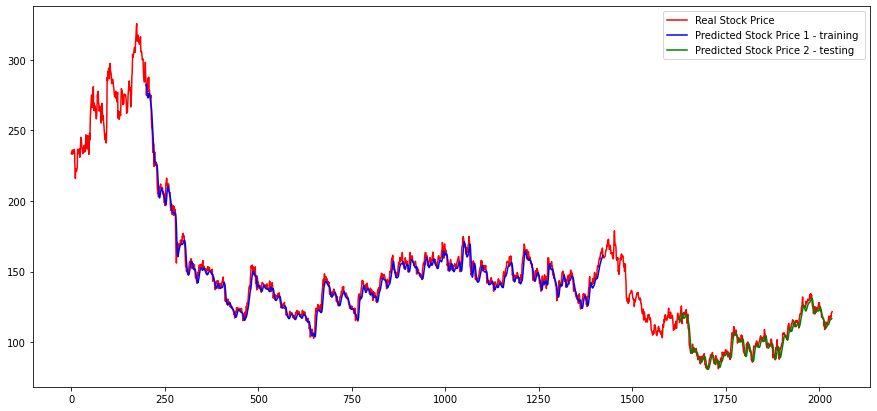

In [27]:
from matplotlib.pyplot import figure
plt.plot(scaler.inverse_transform(df1) , color = 'red', label = 'Real Stock Price')
plt.plot(p1 , color = 'blue', label = 'Predicted Stock Price 1 - training ')
plt.plot(p2 , color = 'green', label = 'Predicted Stock Price 2 - testing ')

plt.rcParams['figure.figsize'] = [15,7]
plt.legend()
plt.show()